In [1]:
#https://stackoverflow.com/questions/54094606/python-direct-volumetric-plot-3d-array
#https://stackoverflow.com/questions/60456336/weight-visualization-of-3d-convolutional-kernel

import numpy as np
from numpy import load
from matplotlib import pyplot as plt
import matplotlib
import  os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)

import keras
from keras import backend as K
from keras.layers.convolutional import Conv2D,Conv3D,Conv2DTranspose,MaxPooling3D,UpSampling3D
from keras.layers import Input, Dense, Activation,Dropout
from keras.layers import concatenate 
from keras.models import Model
from keras.optimizers import Adam

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


Using TensorFlow backend.
/home/sara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sara/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
def plot_slices_kernel(
    model_name, str_fig_name, layer_number, outgoing_channels, incoming_channels, Depth, cmap_input="RdYlGn"
):
    
    # retrieve weights 
    filters, biases = model_name.layers[layer_number].get_weights()

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    n_filters, ix = outgoing_channels, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, :, i]
        # plot each channel separately
        # Range of incoming channels
        for j in range(incoming_channels):
            # Range of Depth of the kernel .i.e. 3
            for k in range(Depth):
                # specify subplot and turn of axis
                #subplot(nrows, ncols, index, **kwargs)
                ax = plt.subplot(n_filters, Depth, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel
                plt.imshow(f[:, :, k,j], cmap=cmap_input, vmin=0, vmax=1)
                ax.set_title("d=" + str(k) + ", f=" + str(i), fontsize=8)
                #pl.colorbar()
                ix += 1
    # show the figure
    if Depth == 7:
        plt.subplots_adjust(bottom=0.1, right=1, top=2)
    else:
        plt.subplots_adjust(bottom=0.1, right=0.5, top=2)
    plt.savefig(str_fig_name+str(cmap_input)+"_slices.pdf", bbox_inches="tight")
    #pl.colorbar()
    plt.show()
   
    return 0



In [3]:
def plot_3D_voxels(
    model_name, str_fig_name, layer_number, outgoing_channels, color_palette="diverging", edge_color="#00000010"
):
    #colors = ['#c2a5cf','#f7f7f7','#a6dba0']
    #colors = ['#f46d4320','#ffffbf10','#66bd6320']
    if color_palette=="diverging":
        colors = ['#d7302715','#ffffbf15','#1a985015']
        #colors = ['#a5002615','#ffffbf15','#00683715']     
    elif color_palette=="gray":
        colors = ['#ffffff30','#bdbdbd30','#00000030']
    else:
        colors = color_palette
    
    levels = [0,.33,.66,1.0]

    # retrieve weights 
    filters, biases = model_name.layers[layer_number].get_weights()

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    n_filters = outgoing_channels
    for i in range(n_filters):
        # get the filter
        vox = filters[:, :, :, 0, i]
       
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_title("filter " + str(i)+"\n")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        # Get rid of colored axes planes
        # First remove fill
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        # Now set color to white (or whatever is "invisible")
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        
        legend_elements  = [Patch(facecolor=colors[0], edgecolor=colors[0], label='between 0 and 0.33'),
                        Patch(facecolor=colors[1], edgecolor=colors[1], label='between 0.33 and 0.66'),
                        Patch(facecolor=colors[2], edgecolor=colors[2], label='between 0.66 and 1')]
    
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        for c in range(3):
            ax.voxels((vox>=levels[c])&(vox<=levels[c+1]),color=colors[c], edgecolor=edge_color)
        plt.savefig(str_fig_name+"_3D_"+str(color_palette)+str(i)+".pdf", bbox_inches="tight")
        plt.show()
    
    
    return 0



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



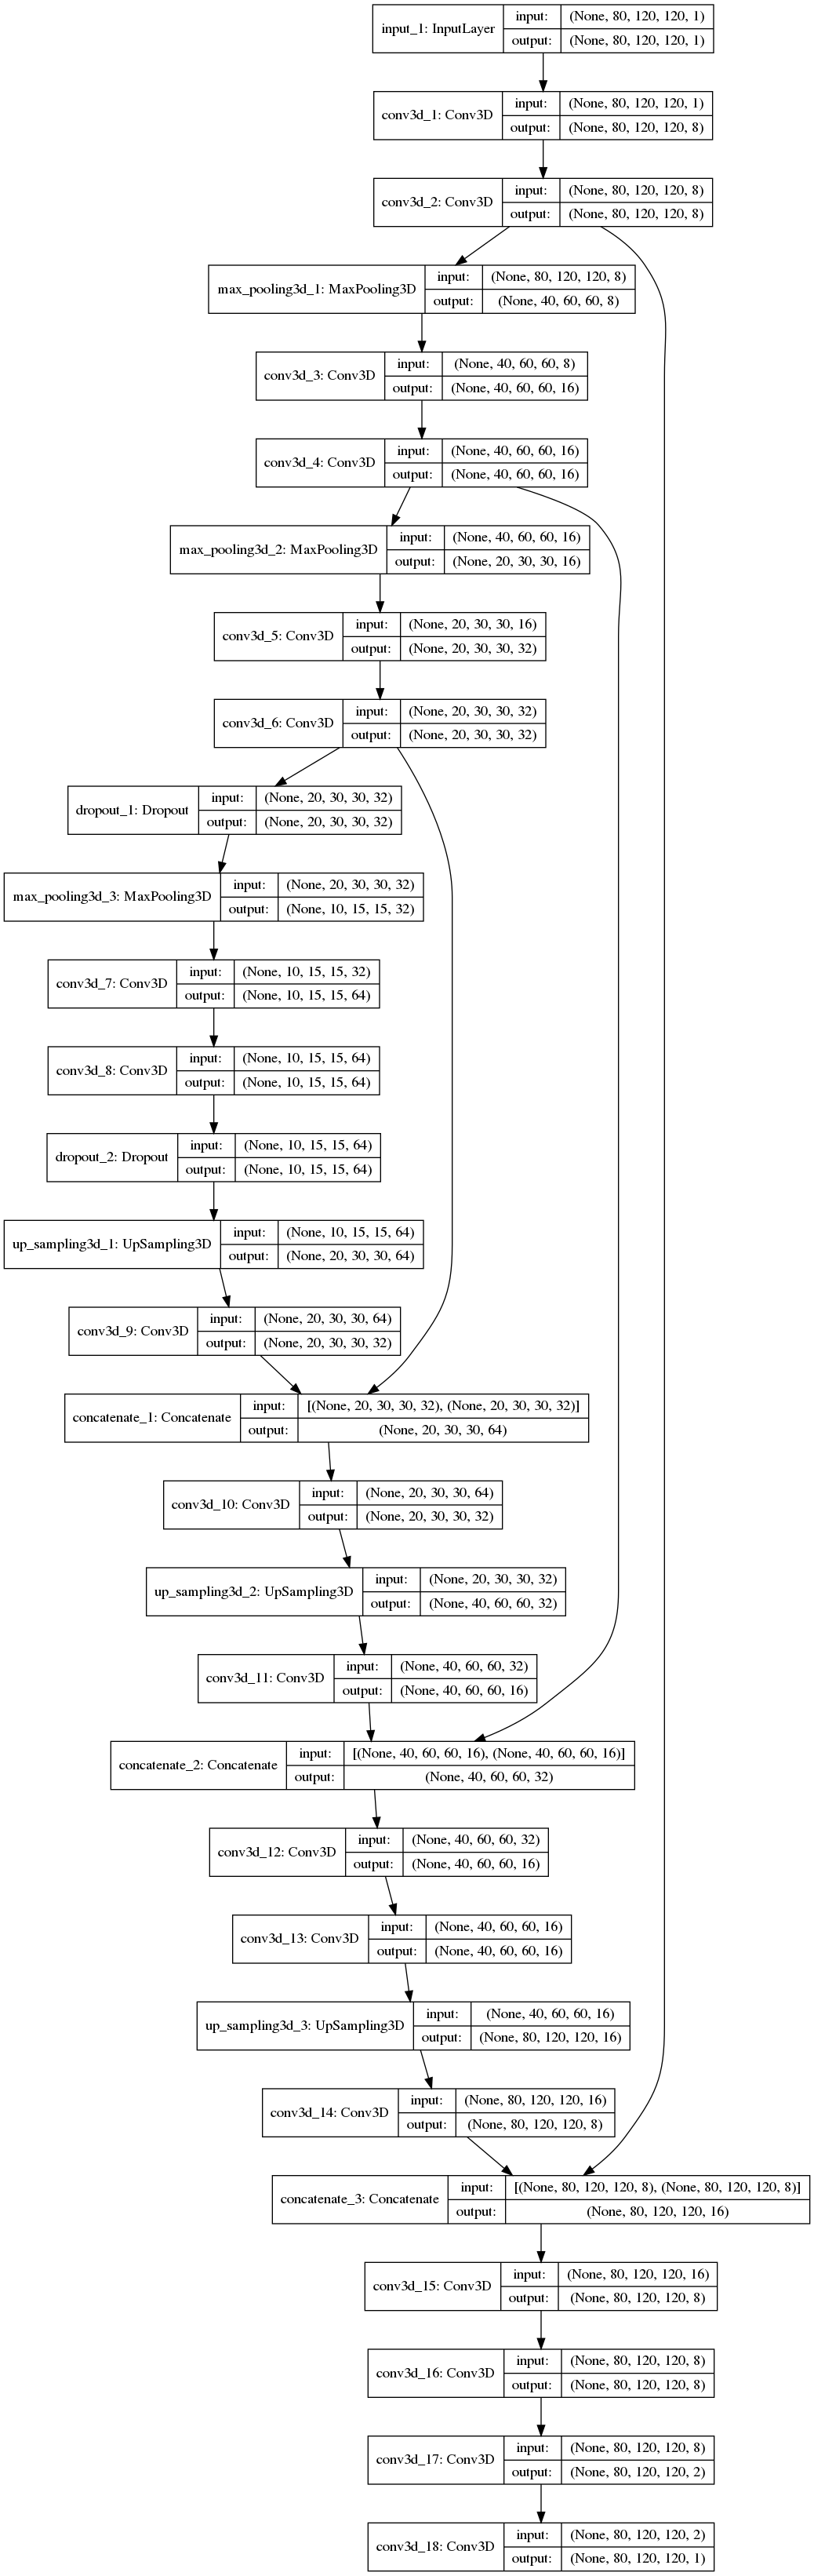

In [4]:
model_041 = keras.models.load_model("model_041-0.1031.h5")
keras.utils.plot_model(model_041, "model_041-0.1031.png", show_shapes=True)

In [5]:
print(model_041.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 120, 120, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 120, 120, 2752        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 80, 120, 120, 21960       conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 40, 60, 60, 8 0           conv3d_2[0][0]                   
____________________________________________________________________________________________

In [6]:
# layer_number: 1 if we want to analyze the first Conv3D layer
# outgoing_channels: number of nodes in the layer (the filter id is indicated as f in the visualization)
# incoming_channels=1 if in weights.shape the 4th number is 1
# Depth: size of the kernel (the slice id is indicated as d in the visualization)

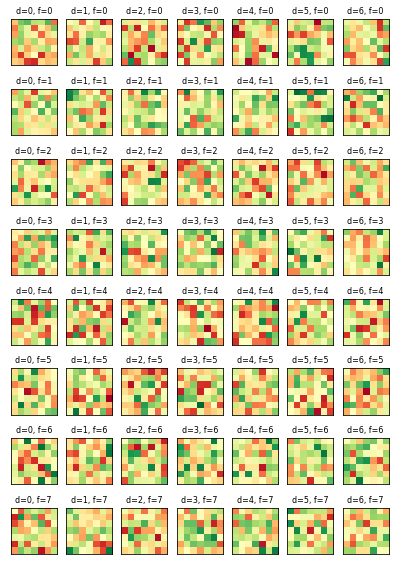

0

In [8]:
# By defeult, cmap_input="RdYlGn". You can input a different cmap
plot_slices_kernel(
    model_name=model_041, 
    str_fig_name="model_041", 
    layer_number=1, 
    outgoing_channels=8, 
    incoming_channels=1, 
    Depth=7
)

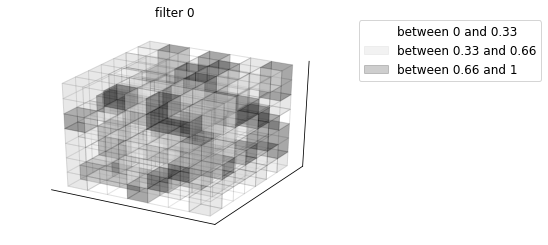

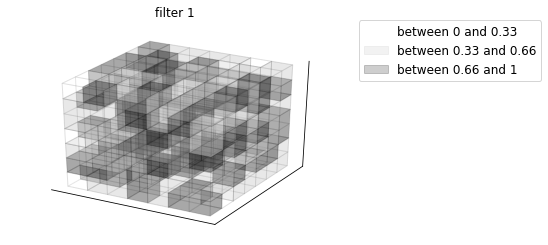

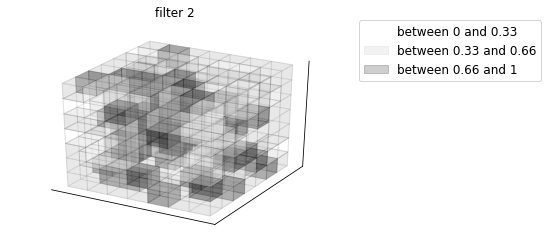

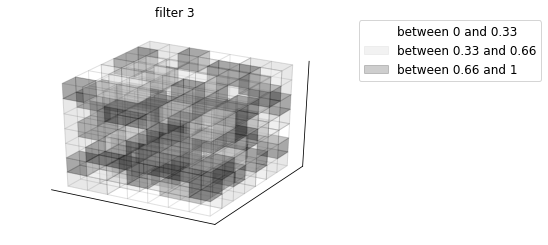

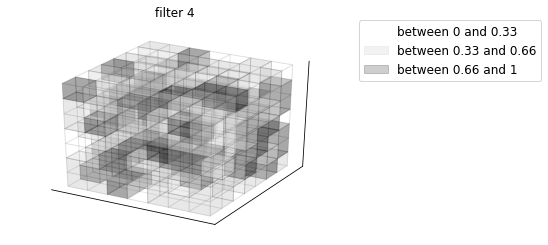

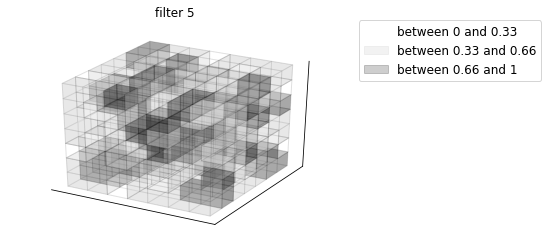

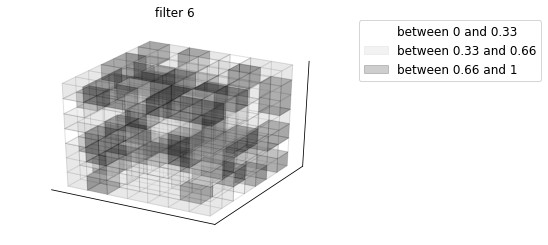

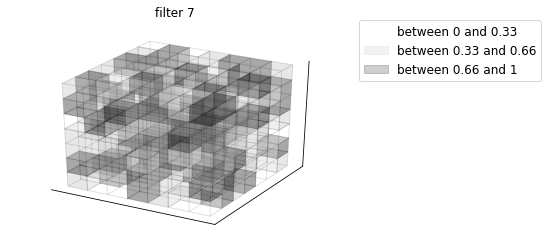

0

In [9]:
#By default:
    #color_palette="diverging" (i.e. ['#a5002615','#ffffbf15','#00683715']) 
        # You can input "gray"(i.e. colors = ['#ffffff30','#bdbdbd30','#00000030'])
        # or you can input a different palette.   
    #edge_color="#00000010". You can imput a different color. 
#The last to digits are the alpha.

plot_3D_voxels(model_041, "model_041", 1, 8,color_palette="gray")

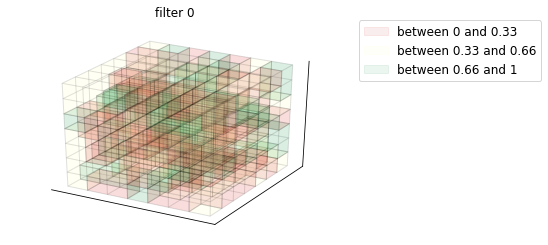

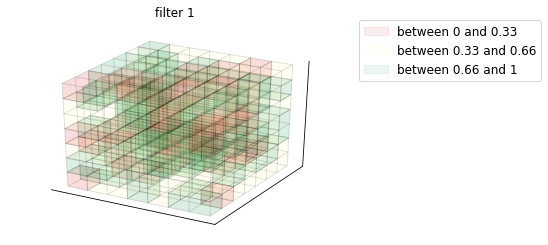

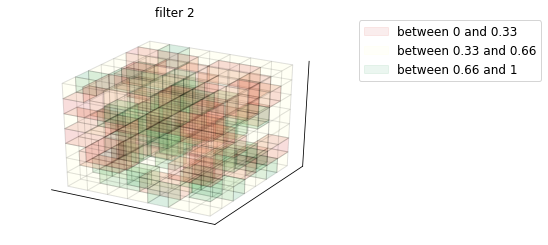

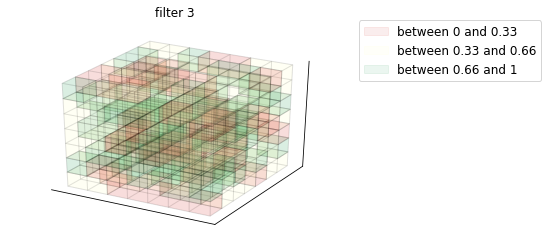

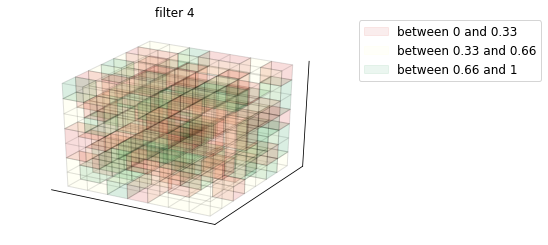

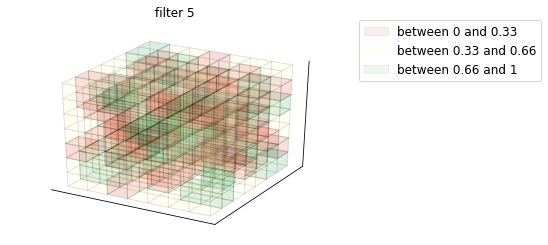

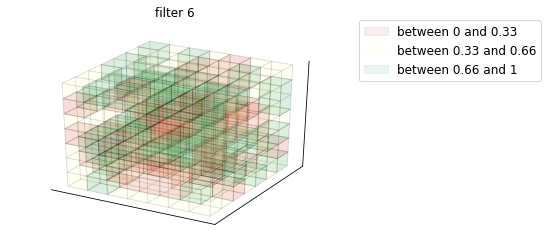

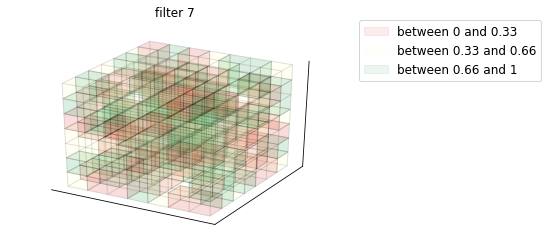

0

In [10]:
plot_3D_voxels(model_041, "model_041", 1, 8)

In [11]:
color_palette_input = ['#d7302710','#ffffbf10','#1a985010']

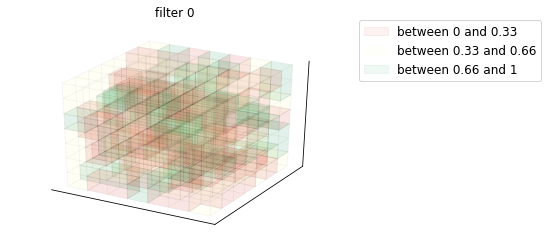

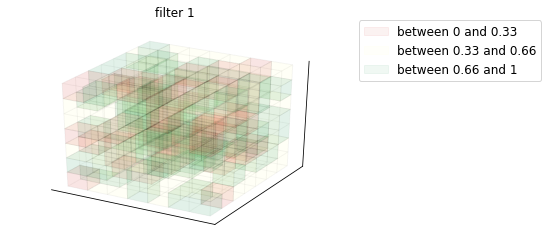

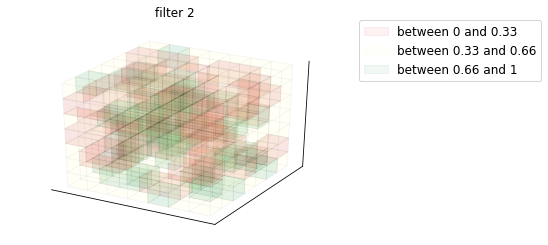

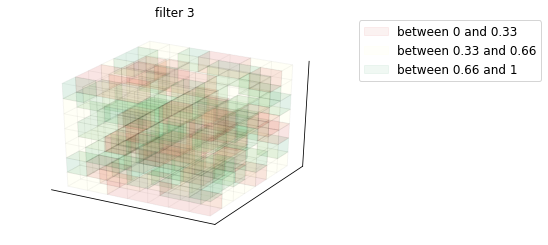

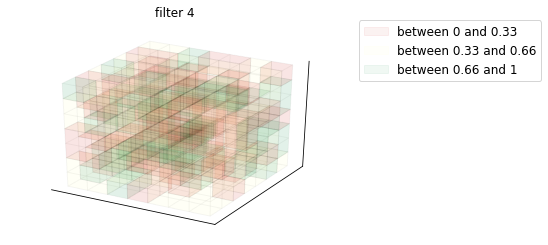

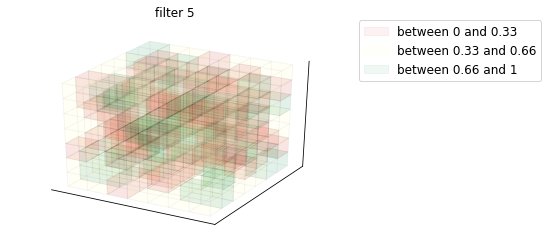

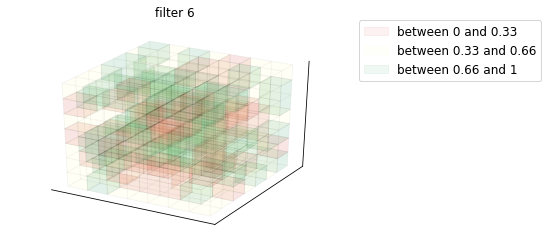

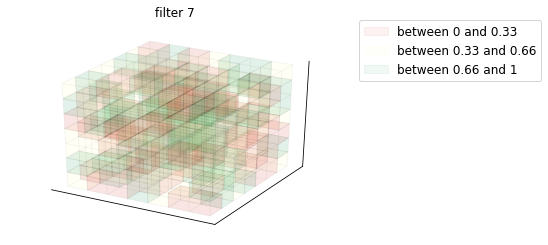

0

In [12]:
plot_3D_voxels(model_041, "model_041", 1, 8, edge_color="#00000005", color_palette=color_palette_input )

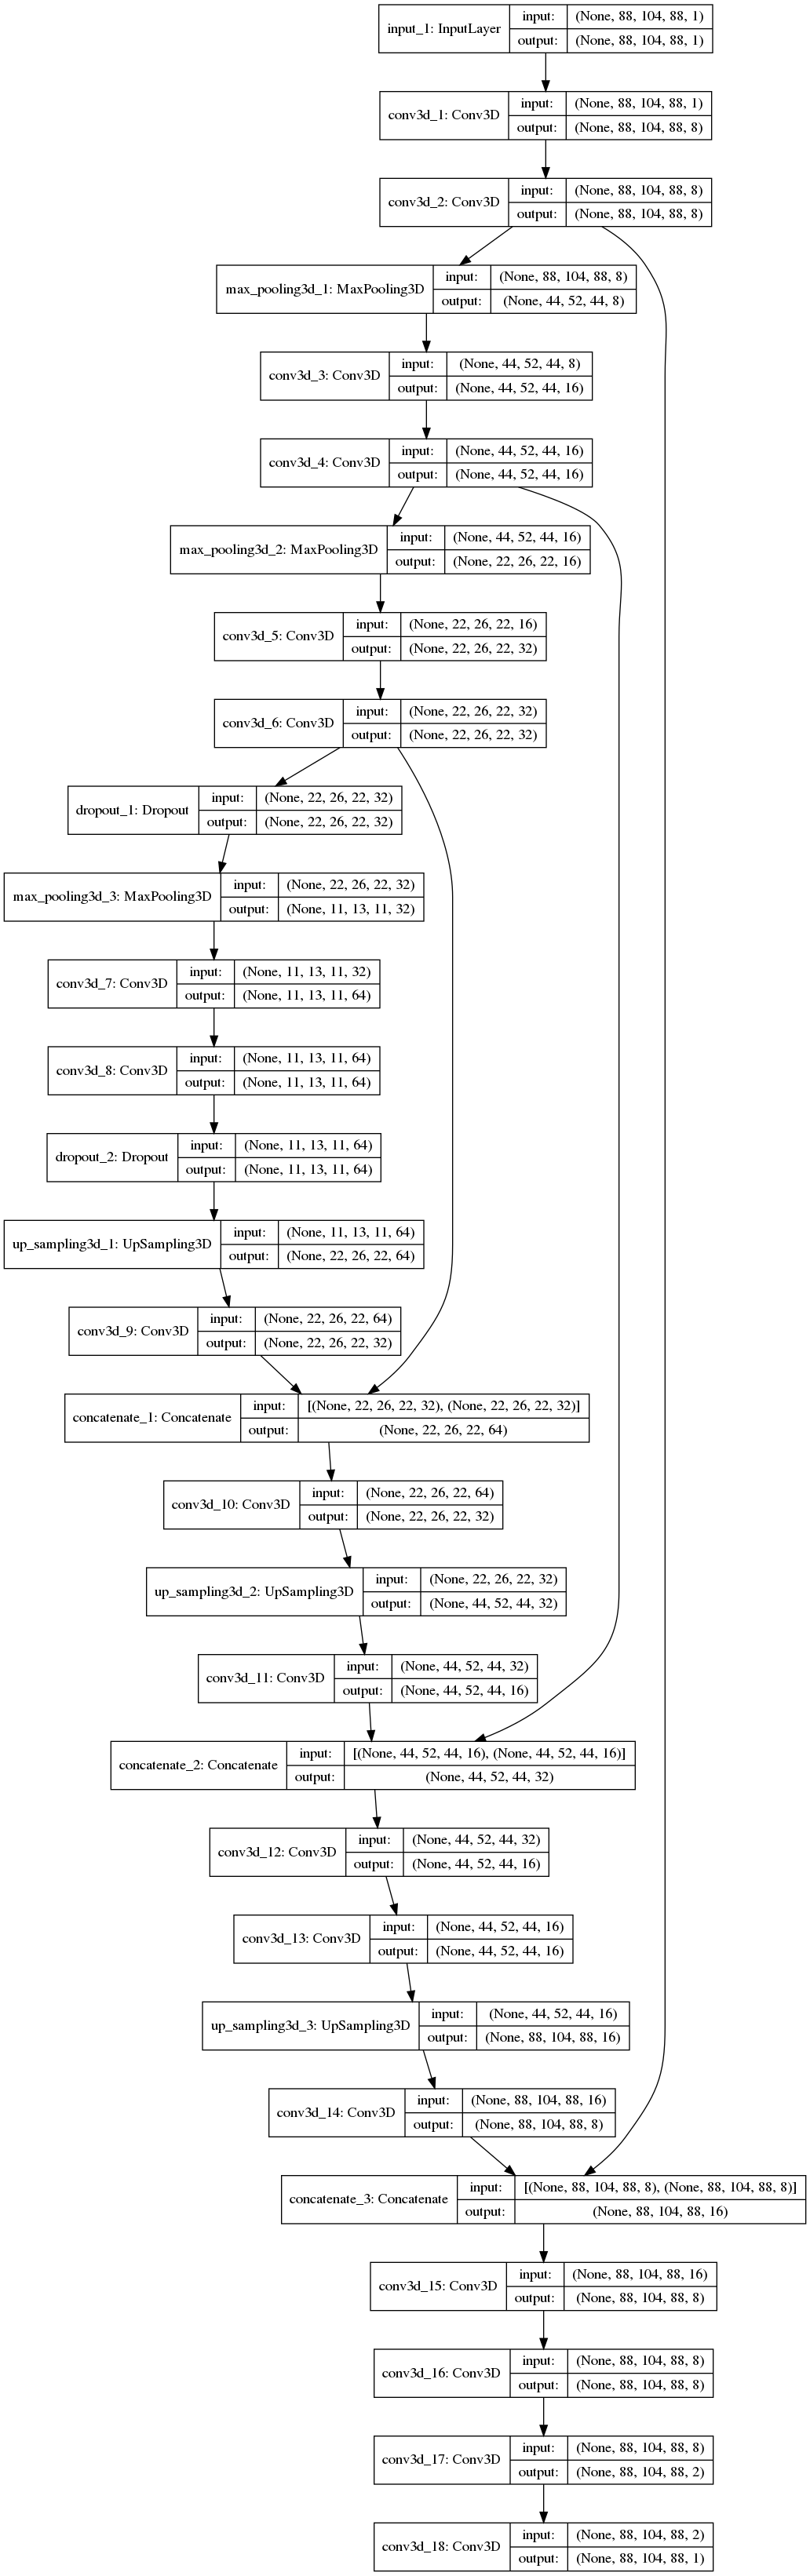

In [13]:
model3x3 = keras.models.load_model("keras_MRI_jimmy.h5")
keras.utils.plot_model(model3x3, "keras_MRI_jimmy.png", show_shapes=True)

In [14]:
print(model3x3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 88, 104, 88,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 88, 104, 88,  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 88, 104, 88,  1736        conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 44, 52, 44, 8 0           conv3d_2[0][0]                   
____________________________________________________________________________________________

(3, 3, 3, 1, 8)


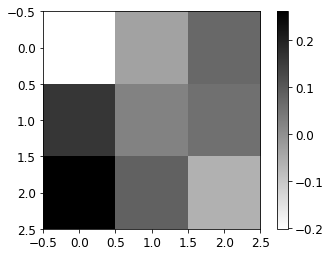

In [15]:
weights, biases = model3x3.layers[1].get_weights()
print(weights.shape)

plt.imshow(weights[:,:,0,0,1],cmap="gray_r")
pl.colorbar()

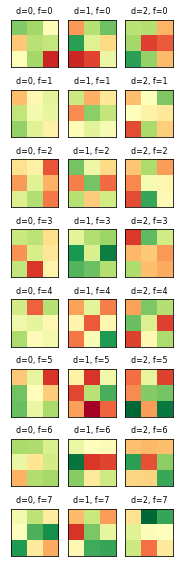

0

In [16]:
plot_slices_kernel(model_name=model3x3,str_fig_name="model3x3", layer_number=1, outgoing_channels=8, incoming_channels=1, Depth=3)

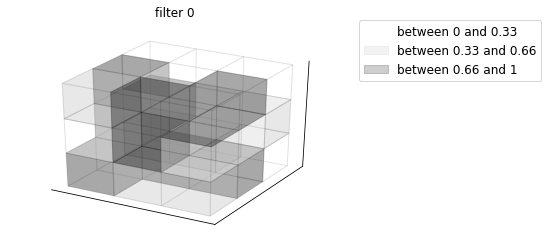

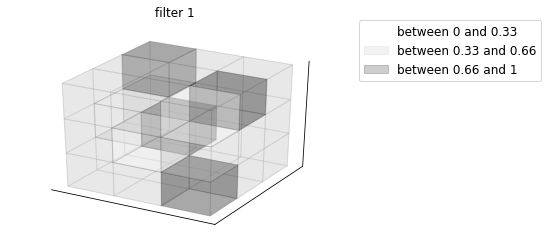

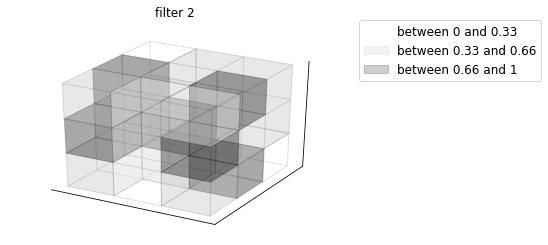

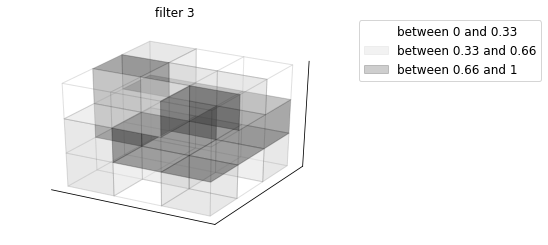

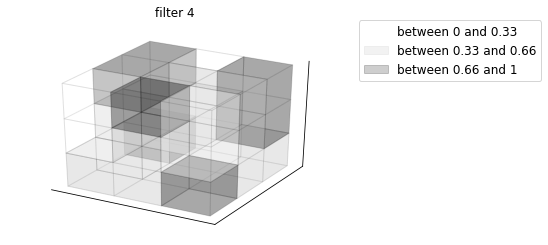

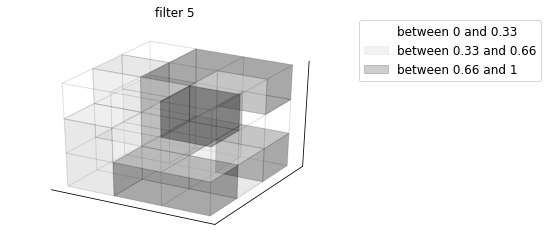

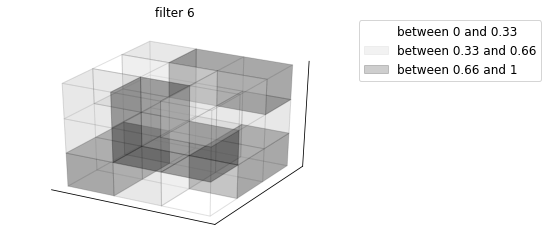

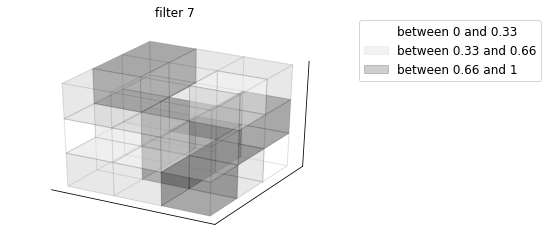

0

In [17]:
plot_3D_voxels(model3x3,"model3x3", 1, 8,color_palette="gray")

In [18]:
color_palette_input = ['#d7302730','#ffffbf30','#1a985030'] 

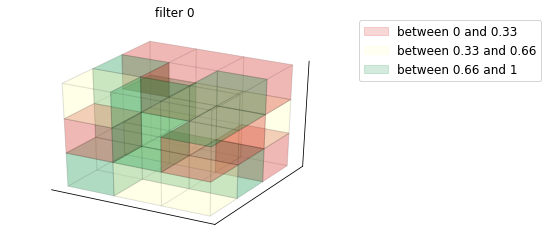

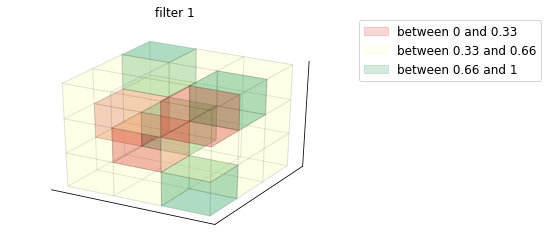

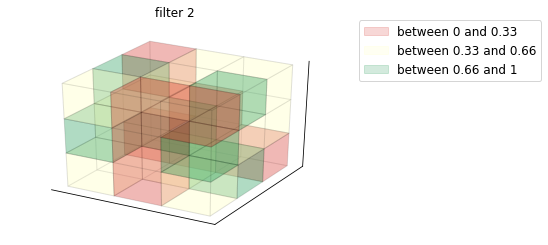

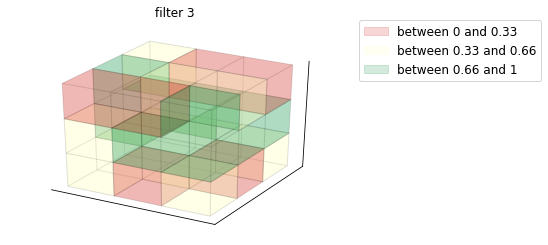

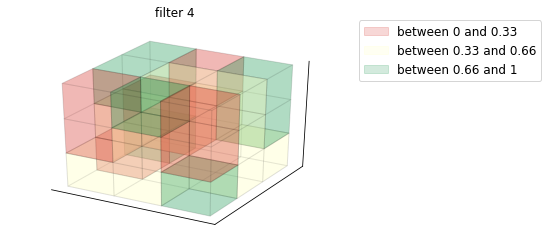

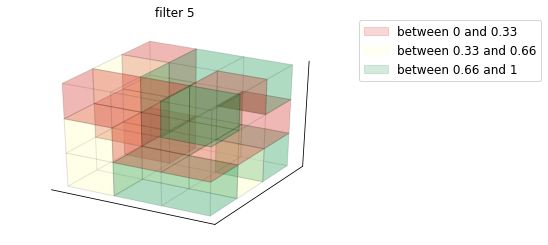

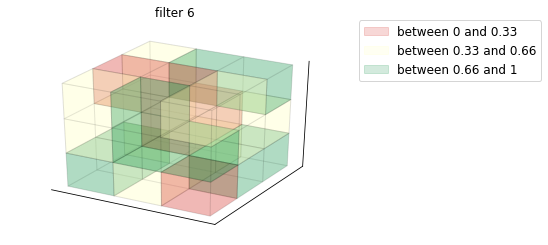

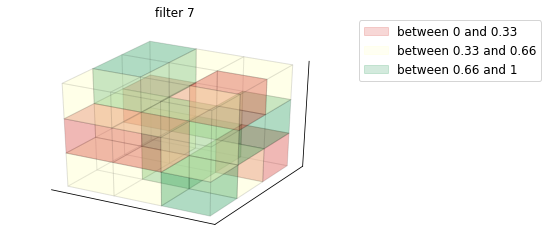

0

In [19]:
plot_3D_voxels(model3x3,"model3x3", 1, 8, color_palette=color_palette_input)

Weights before the training

In [20]:
input_size = (88,104,88,1)

inputs = Input(input_size)
conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(drop3)

conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

up5 = Conv3D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop4))
merge5 = concatenate([conv3,up5], axis = 4)
conv5 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)

up6 = Conv3D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv5))
merge6 = concatenate([conv2,up6], axis = 4)
conv6 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv3D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
merge7 = concatenate([conv1,up7], axis = 4)
conv7 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv8 = Conv3D(1, 1, activation = 'sigmoid')(conv7)

model_random = Model(input = inputs, output = conv8)

model_random.compile(optimizer = Adam(lr = 1e-4), loss = "binary_crossentropy", metrics = ['accuracy'])

model_random.save_weights("my_keras_weights2.ckpt")

print(model_random.summary())

/home/sara/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 88, 104, 88,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 88, 104, 88,  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 88, 104, 88,  1736        conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 44, 52, 44, 8 0           conv3d_2[0][0]                   
____________________________________________________________________________________________

In [21]:
# saving the model
SAVE_DIR = "./"
MODEL_NAME = 'keras_MRI_train3_before_train.h5'
model_path = os.path.join(SAVE_DIR, MODEL_NAME)

model_random.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./keras_MRI_train3_before_train.h5 


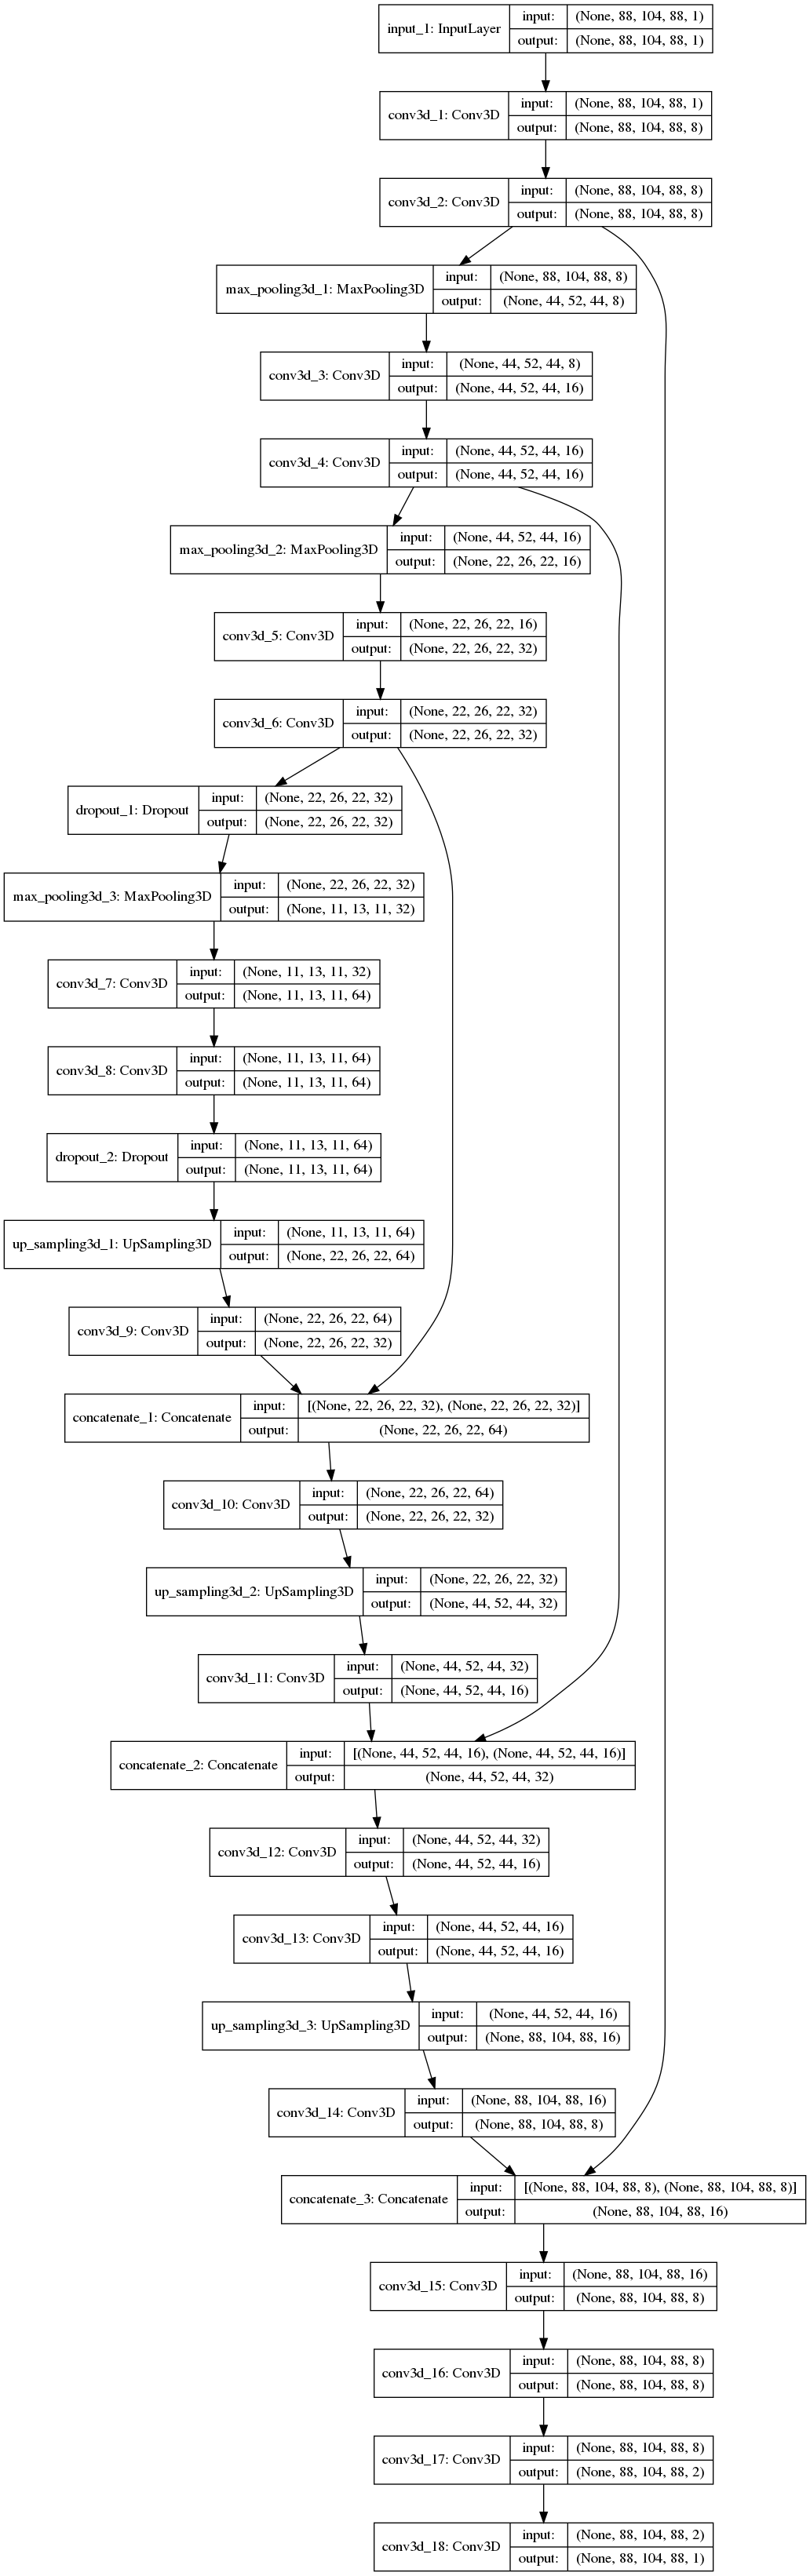

In [22]:
model_random = keras.models.load_model("keras_MRI_train3_before_train.h5")
keras.utils.plot_model(model_random, "keras_MRI_train3_before_train.png", show_shapes=True)

(3, 3, 3, 1, 8)


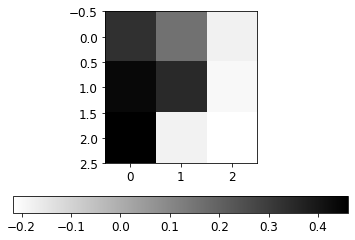

In [23]:
weights, biases = model_random.layers[1].get_weights()
print(weights.shape)

plt.imshow(weights[:,:,0,0,1],cmap="gray_r")
pl.colorbar(orientation= "horizontal")

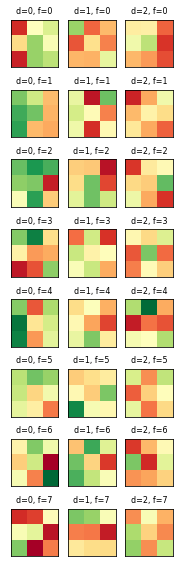

0

In [24]:
plot_slices_kernel(
    model_name=model_random,
    str_fig_name="model3_before_training", 
    layer_number=1, 
    outgoing_channels=8, 
    incoming_channels=1, 
    Depth=3
)

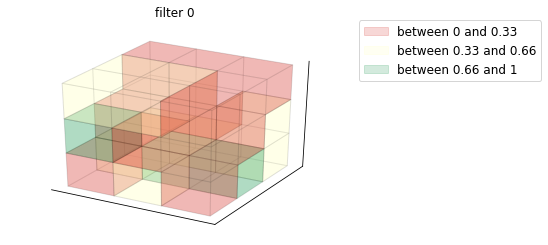

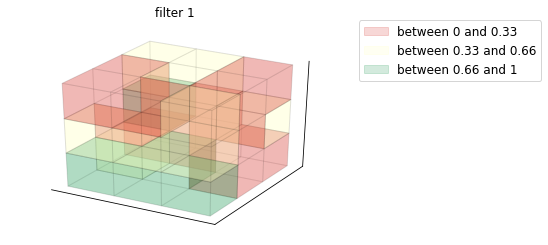

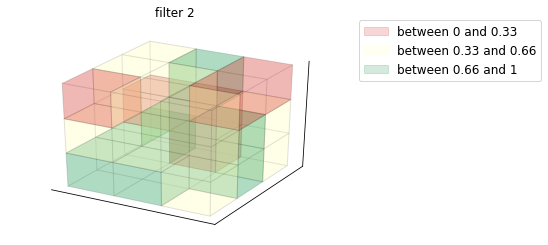

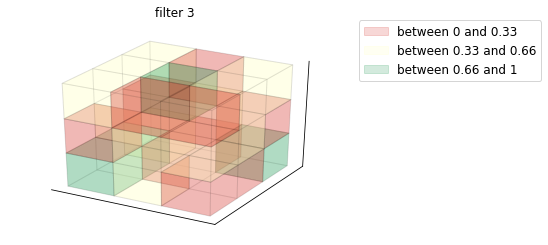

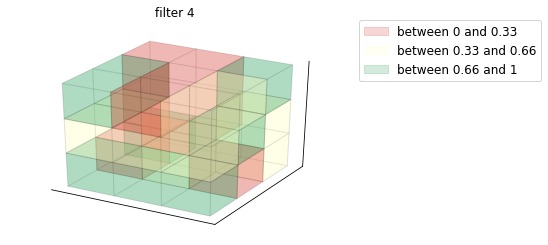

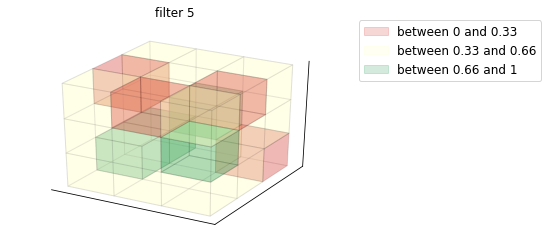

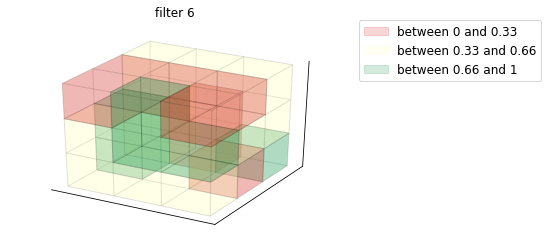

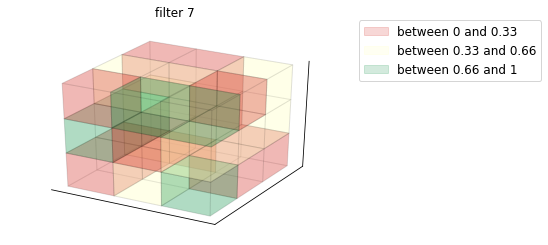

0

In [25]:
plot_3D_voxels(model_random,"model3_before_training", 1, 8, color_palette=color_palette_input)